# Challenge 1 - Energy Production Data Simulation

###Soma Suzuki

Using data from July 2011 to May 2013, I will predict EnergyProduction on June 2013 for each house, and calculate MAPE(Mean Absolute Percentage Error).

## 1.Data exploration.

In [1]:
#import module
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as st
import statsmodels.tsa.vector_ar.var_model as var
import statsmodels.api as sm
import math
from matplotlib import style
style.use('ggplot')
%matplotlib inline

In [2]:
#read data-set
data_train = pd.read_csv('../../data/training_dataset_500.csv')
data_test = pd.read_csv('../../data/test_dataset_500.csv')
rang=pd.date_range('7/1/2011', '6/1/2013', freq='M')

In [3]:
#jsut check data_train
data_train.head(5)

,ID,Label,House,Year,Month,Temperature,Daylight,EnergyProduction
0,0,0,1,2011,7,26.2,178.9,740
1,1,1,1,2011,8,25.8,169.7,731
2,2,2,1,2011,9,22.8,170.2,694
3,3,3,1,2011,10,16.4,169.1,688
4,4,4,1,2011,11,11.4,169.1,650


In [4]:
#jsut check data_test
data_test.head(5)

,ID,Label,House,Year,Month,Temperature,Daylight,EnergyProduction
0,23,23,1,2013,6,22.0,125.5,778
1,47,23,2,2013,6,21.1,123.1,627
2,71,23,3,2013,6,21.9,126.8,735
3,95,23,4,2013,6,20.2,125.2,533
4,119,23,5,2013,6,20.2,125.2,533


As there seems many duplicated dates in data_train. 
I checked If the datas are duplicated or not. 

Number of unique houses: 28


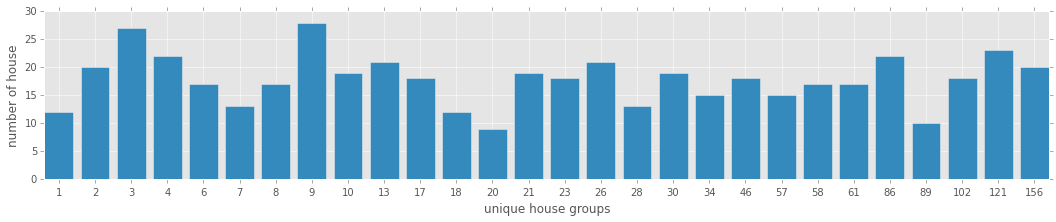

In [5]:
data_per_house=[tuple([tuple(data_train[data_train.House==x][column]) for column in ['Temperature','Daylight','EnergyProduction']]) for x in range(1,501)]
data_unq=[]
enu_element=[]
for i, v in enumerate(data_per_house):
    if not v in enu_element:
        enu_element.append(v)
        data_unq.append(i+1)
        
data_unq_len = len(set(data_per_house))
print "Number of unique houses: " + str(data_unq_len)
plt.figure(figsize=(18,3))
plt.bar(np.arange(data_unq_len), map(lambda i: data_per_house.count(i), set(data_per_house)), align='center')
plt.xticks(np.arange(data_unq_len), data_unq)
plt.xlabel('unique house groups'); plt.ylabel('number of house');
plt.autoscale(axis='x')

From the graph above, it is revealed that almost all of dates are duplicated and that there are only 28 unique dates in data_train.
I wondered if I should use "data_train" which includes a lot of duplicated data, or I should make another data set which only includes unique data(I will call it "data_uniqu").
Although I am not fully sure which datas I should use, I decided to choose "data_uniqu" for two reasons.

1,Each unique house group has different numbers of duplicated data, and the predction can be depend on the number of the duplicates, which can cause inaccuracy of prediction for EnergyProduction.

2,In this time series analysis, the prediction for EnergyProduction of each house would be built only with datas of the each individual house. Therefore, deleting duplicated data is acceptable.

I will also calculte MAPE from "data_train" and will compare it with MAPE from "data_uniqu".

### Choose algorithm.

To decide an algorithm, I checked correlations of Temperature, Daylight and EnergyProduction.

In [6]:
data_uniqu = data_train[data_train['House'].isin(data_unq)]
data_uniqu[['EnergyProduction','Daylight','Temperature']].corr()

,EnergyProduction,Daylight,Temperature
EnergyProduction,1.000000,0.519554,0.258481
Daylight,0.519554,1.000000,-0.055286
Temperature,0.258481,-0.055286,1.000000


As shown in the above table, EnergyProduction is positively corelated not only with Daylight but also with Temperature.
The table also showed that there is no relation between Daylight and Temperature.

Therefore I will use VAR (vector autoregressive) model for predicting EnergyProduction of each house.
(There is a model caled VARMA model. But I could not find a good resource to implement VARMA model.)

note:
VAR model is a multiple time series generalization of the AR model.
VARMA model is a multiple time series generalization of the ARMA model.


## 2.Data analysis.

When using VAR model, it is very important to check whether a data is stationary or not.
Only stationary data can be used in VAR model.

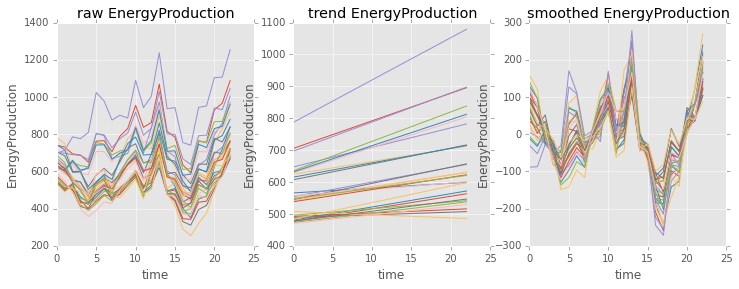

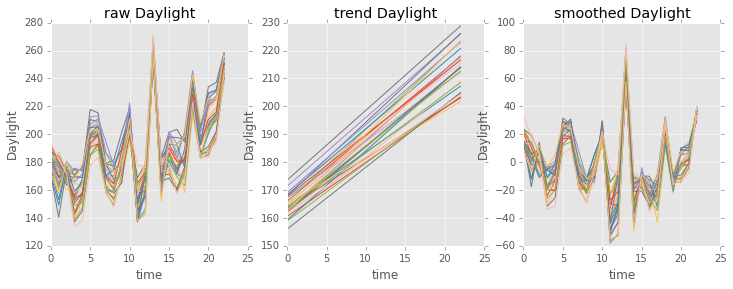

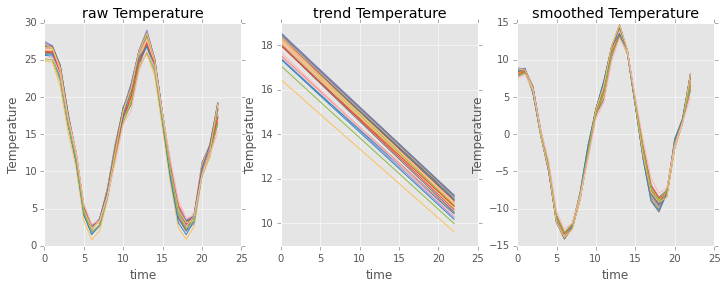

In [9]:

fig, axes = plt.subplots(figsize=(12,4), ncols=3)

for i in data_unq:
    house[i] = data_uniqu[data_uniqu.House==i][['EnergyProduction']].set_index(rang)
    i_smoothed, i_trend = sm.tsa.filters.hpfilter(house[i], lamb=129600)
    axes[0].plot(house[i])
    axes[0].set_title('raw EnergyProduction')
    axes[0].set_xlabel('time')
    axes[0].set_ylabel('EnergyProduction')
    axes[1].plot(i_trend)
    axes[1].set_title('trend EnergyProduction')
    axes[1].set_xlabel('time')
    axes[1].set_ylabel('EnergyProduction')
    axes[2].plot(i_smoothed)
    axes[2].set_title('smoothed EnergyProduction')
    axes[2].set_xlabel('time')
    axes[2].set_ylabel('EnergyProduction')


fig, axes = plt.subplots(figsize=(12,4), ncols=3)   
for j in data_unq:
    house[j] = data_uniqu[data_uniqu.House==j][['Daylight']].set_index(rang)
    j_smoothed, j_trend = sm.tsa.filters.hpfilter(house[j], lamb=129600)
    axes[0].plot(house[j])
    axes[0].set_title('raw Daylight')
    axes[0].set_xlabel('time')
    axes[0].set_ylabel('Daylight')
    axes[1].plot(j_trend)
    axes[1].set_title('trend Daylight')
    axes[1].set_xlabel('time')
    axes[1].set_ylabel('Daylight')
    axes[2].plot(j_smoothed)
    axes[2].set_title('smoothed Daylight')
    axes[2].set_xlabel('time')
    axes[2].set_ylabel('Daylight')

fig, axes = plt.subplots(figsize=(12,4), ncols=3)   
for k in data_unq:
    house[k] = data_uniqu[data_uniqu.House==k][['Temperature']].set_index(rang)
    k_smoothed, k_trend = sm.tsa.filters.hpfilter(house[k], lamb=129600)
    axes[0].plot(house[k])
    axes[0].set_title('raw Temperature')
    axes[0].set_xlabel('time')
    axes[0].set_ylabel('Temperature')
    axes[1].plot(k_trend)
    axes[1].set_title('trend Temperature')
    axes[1].set_ylabel('Temperature')
    axes[1].set_xlabel('time')
    axes[2].plot(k_smoothed)
    axes[2].set_title('smoothed Temperature')
    axes[2].set_ylabel('Temperature')
    axes[2].set_xlabel('time')
    

As shown in graphs above, EnergyProduction, Daylight and Temperature obviously have trend components and and are unstationary. (smoothed data is a data in which trend components are removed.)

As the above graphs also prove that each house has a similar wave shape, I will use "house 1" to plot and check the first natural logarithm　differences of the three variables in order to to remove the trend components.

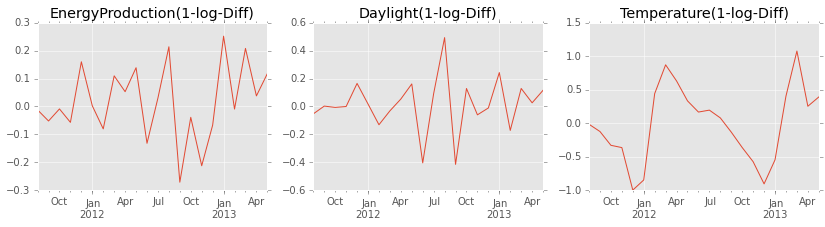

In [10]:
rang=pd.date_range('7/1/2011', '6/1/2013', freq='M')
house1 = data_train[data_train.House==1][['EnergyProduction','Daylight','Temperature']].set_index(rang)

fig, axes = plt.subplots(ncols=3)
for i, column in enumerate(house1.columns):
    np.log(house1[column]).diff().dropna().plot(ax=axes[i], figsize=(14,3), title=column+'(1-log-Diff)')

By taking an unit root test (Dickey-Fuller test), I check if trend components are actually removed.

In [11]:
print 'P-values of the root unit test'
print 'EnergyProduction: ' + str(round(st.adfuller(np.log(house1.EnergyProduction).diff().dropna())[1],10))
print 'Daylight:         ' + str(round(st.adfuller(np.log(house1.Daylight).diff().dropna())[1],10))
print 'Temperature:      ' + str(round(st.adfuller(np.log(house1.Temperature).diff().dropna())[1],10)) 

P-values of the root unit test
EnergyProduction: 0.954496376
Daylight:         3e-09
Temperature:      0.2051110118


Judging from the unit root test, taking the first natural logarithm　differences failed to get rid of trend components from three valuables. (EnergyProduction: 0.954496376....)
Then I will plot and check the first differences of the three variables.

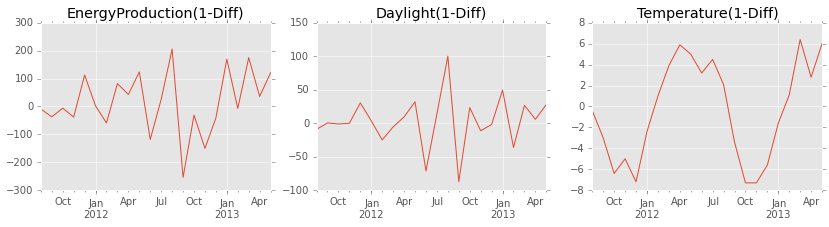

In [12]:
fig, axes = plt.subplots(ncols=3)
for i, column in enumerate(house1.columns):
    house1[column].diff().dropna().plot(ax=axes[i], figsize=(14,3), title=column+'(1-Diff)')

Again, I will take the unit root test (Dickey-Fuller test) to check if trend components are actually removed.

In [13]:
print 'P-values of root unit test'
print 'EnergyProduction: ' + str(round(st.adfuller(house1.EnergyProduction.diff().dropna())[1],10))
print 'Daylight:         ' + str(round(st.adfuller(house1.Daylight.diff().dropna())[1],10))
print 'Temperature:      ' + str(round(st.adfuller(house1.Temperature.diff().dropna())[1],10)) 

P-values of root unit test
EnergyProduction: 9.4942e-06
Daylight:         6.6e-09
Temperature:      3.426e-07


Finally, the trend components are successfully removed from three variables.
Each P-value is small enough!! (At last, better than previous one.)

To actually do the estimation, it is very important to decide a lag order.
I will check AIC, BIC and FPE to decide the lag order.

In [14]:
data_unique = data_uniqu[data_uniqu.House==156][['EnergyProduction','Daylight','Temperature']].set_index(rang)
data_unique_diff = data_unique.diff().dropna()
model_unique = var.VAR(data_unique_diff)
model_unique.select_order(5)

                 VAR Order Selection                 
           aic          bic          fpe         hqic
-----------------------------------------------------
0        17.54        17.68    4.132e+07        17.55
1        16.52        17.10    1.529e+07        16.57
2        16.41        17.44    1.563e+07        16.51
3        15.58        17.05    9.842e+06        15.73
4        11.67        13.58    5.032e+05        11.86
5      -60.21*      -57.86*   8.974e-25*      -59.98*
* Minimum



{'aic': 5, 'bic': 5, 'fpe': 5, 'hqic': 5}

As shoen in above table, when the lag length is 5, it minimizes AIC, BIC and FPE for the VAR model.
For the cointegration, the lag length is the lag length chosen from previous criteria minus one, as I am running the model in first difference now.
Therefore, I choose 4 as the lag order.
I will plott residuals of three variables. (just for curious.)

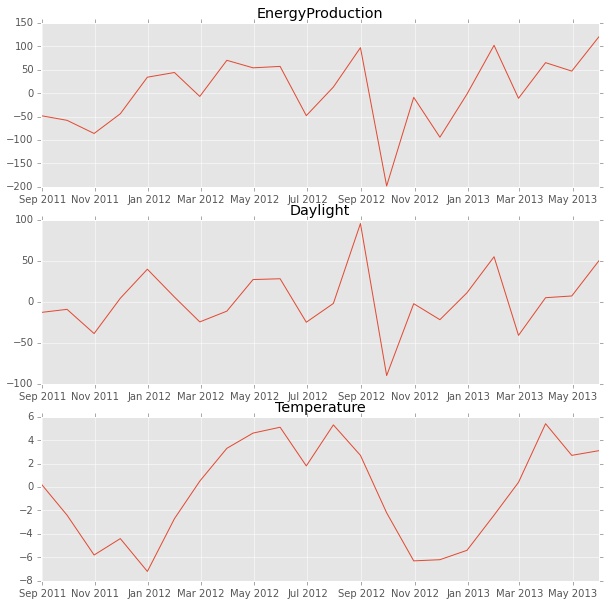

In [15]:
lag_order = 4
results_unique = model_unique.fit(lag_order, trend='nc')
results_unique.plot()

I also plot Autocorrelations of three variables to check whether there are Autocorrelations or not.

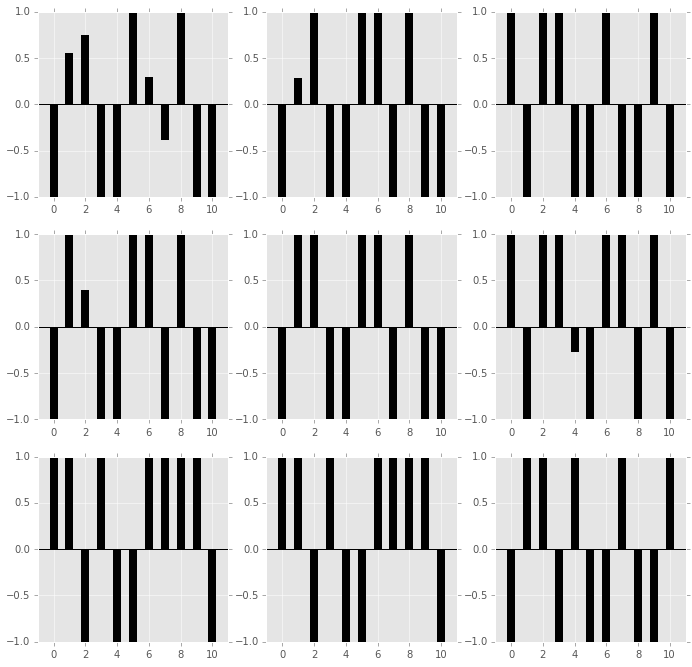

In [16]:
results_unique.plot_acorr()

Judging from above graphs, there still are Autocorrelations of three variables, although I took the unit root test (Dickey-Fuller test) to check if trend components are actually removed. (The result showed trend components was successfully removed!)
I will mention about it again at the conclusion part.

## 3.Prediction and evaluation.

Finaly I will predict EnergyProduction on June 2013 for each house.
First, I will use data_uniqu to make a prediction and calculate MAPE.
Next, for comparison, I will use data_train to predict EnergyProduction.

In [17]:
def VAR_model(data_type, pred_file, mape_file):
    file_pred = open(pred_file, 'w')
    file_mape = open(mape_file, 'w')
    pred_writer = csv.writer(file_pred)
    pred_writer.writerow(['House','EnergyProduction'])
    sum0 = 0
    for i in data_type:
        data = data_train[data_train.House==i][['EnergyProduction','Daylight','Temperature']].set_index(rang)
        data_diff = data.diff().dropna()
        model = var.VAR(data_diff)
        results = model.fit(lag_order, trend='nc')
        data_pred = results.forecast(data_diff.values[-lag_order:],1)[0,0]+data.EnergyProduction[-1]
        sum0 += abs(data_pred-data_test.EnergyProduction[i-1])/data_test.EnergyProduction[i-1]
        pred_writer.writerow([i,data_pred])
    mape = round(sum0/len(data_type),3)
    file_mape.write(str(mape))
    file_pred.close()
    file_mape.close()

    return mape
    
    
print 'MAPE: ' + str(VAR_model(data_unq, 'pred_unique.csv','mape_unique.txt')) + ' (unique houses) '
print 'MAPE: ' + str(VAR_model(range(1,501), 'pred_all.csv','mape_all.txt')) + ' (all houses)'



MAPE: 0.098 (unique houses) 
MAPE: 0.097 (all houses)


## Conclusion and Summary.

As a conclusion, MAPE is 0.098 when using data_uniqu and is 0.097 when using data_train.
Against my anticipation, I got a better prediction from data_train..
Possible reasons are because I did not get rid of seasonal components.
I tryed to remove it but the data for training cover only 22 months and it is too short to remove seasonal components.(At least, we need datas for three years.)

I also expected that taking the first natural logarithm differences of the three variable would gives me much more stationary data than when taking the first difference. However I got unstationary data from taking the first natural logarithm　differences, which, I think, is also because of seasonal components.